<a href="https://colab.research.google.com/github/sayarghoshroy/Intro_to_DL_tutorial/blob/master/training_a_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

## *Example 4: Train a Neural Network on a Real World Dataset*

### $ Predict\ Concrete\ Compressive\ Strength.$

In [0]:
# loading the data
data_read = pd.read_excel('./Concrete_Data.xls')
data = data_read.values
# the last column of the data is what we are trying to predict

print("Dimensions of the Dataset: " + str(np.shape(data)))

Dimensions of the Dataset: (1030, 9)


In [0]:
# Splitting the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(data[:, 0:8], data[:, 8], test_size = 0.3, random_state = 2020)

In [0]:
# Data Normalization
# Note that we are only observing our training set

train_mean = np.mean(X_train, axis = 0)
train_var = np.mean(X_train, axis = 0)

X_train = (X_train -  train_mean) / np.sqrt(train_var)
X_test = (X_test - train_mean) / np.sqrt(train_var)
# Pre-processing Step

#### $ Building\ Neural\ Network\ and\ defining\ Gradients$

$ y' = W_2.f(W_1^TX)$

$where:$

- $\ W_1\ is\ of\ size\ 8\ \times\ n\_nodes$

- $\ W_2\ is\ of\ size\ 1\ \times\ n\_nodes$

- $\ f\ is\ the\ activation\ for\ the\ hidden\ layer$

- $\ X\ is\ the\ data\ matrix\ of\ size\ 8\times [batch\ size]$

<br>

$ Mean\ Squared\ Error = \frac{1}{N}(y - y')^T (y - y') $

$ = \frac{1}{N} (y^Ty - y^Ty' - y'^Ty +y'^Ty') = L$

<br>

$ \frac{\partial L}{\partial W_2} = \frac{1}{N}(2y'.\frac{\partial y'}{\partial W_2} - 2y. \frac{\partial y'}{\partial W_2})$

$= \frac{2}{N}(y' - y).f(W_1^TX)$

<br>

$ \frac{\partial L}{\partial W_1} = \frac{2}{N}(y' - y) \frac{\partial y'}{\partial W_1}$

$ = \frac{2}{N}(y' - y).W_2 \odot f'(W_1^T X).X^T$

<br>

$ -\ where\ f'\ is\ the\ derivative\ of\ the\ activation\ function$

<br>

$ NOTE:\ No\ biases\ have\ been\ used\ so\ far.$

In [0]:
batch_size = 200

def forward(X, W_1, W_2, f):
    y_prime = np.matmul(W_2, f(np.matmul(W_1.T, X.T)))
    return y_prime

def convergence(losses):
    if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < 1e-4:
        return True
    return False

def plot_losses(errors):
    fig = plt.figure(figsize=(9, 9))
    p = fig.add_subplot('111')
    p.set_title('Error v/s Epoch')
    p.set_xlabel('Epoch Number')
    p.set_ylabel('Error')
    losses = [x for x in errors]
    p.plot(list(range(1, len(losses))), losses[1:])
    plt.show()

In [0]:
def batch_backprop_train(nodes, f, f_prime, random_seed = 2020, max_iter = int(1e5)):
    np.random.seed(seed = random_seed)
    W_1 = np.random.random_sample((8, nodes))
    np.random.seed(seed = random_seed)
    W_2 = np.random.random_sample((1, nodes))

    eta = 1e-4 * 5
    
    iteration = 0

    train_loss = []

    while iteration < max_iter and convergence(train_loss) == False:
        # random batch selection
        indices = np.random.randint(0, X_train.shape[0], batch_size)
        sample = X_train[indices]
        y = y_train[indices]

        train_loss.append(np.power(np.linalg.norm(y_train - forward(X_train, W_1, W_2, f)), 2) / np.shape(y_train)[0])

        y_prime = forward(sample, W_1, W_2, f)

        partial_L_W_1 = (2 / batch_size) * (np.multiply( (np.asmatrix(y_prime - y).T @ W_2).T, f_prime(W_1.T @ sample.T)) @ sample).T
        partial_L_W_2 = (2 / batch_size) * np.matmul(np.asmatrix(y_prime - y), f(np.matmul(W_1.T, sample.T).T))

        W_1 = W_1 - eta * partial_L_W_1
        W_2 = W_2 - eta * partial_L_W_2
        
        iteration += 1
    
    test_error = np.power(np.linalg.norm(y_test - forward(X_test, W_1, W_2, f)), 2) / np.shape(y_test)[0]
    return train_loss, test_error, W_1, W_2

Hidden Layer Activation = relu
MSE on Train Set: 97.83895167082841
MSE on Test Set: 126.53917451740035


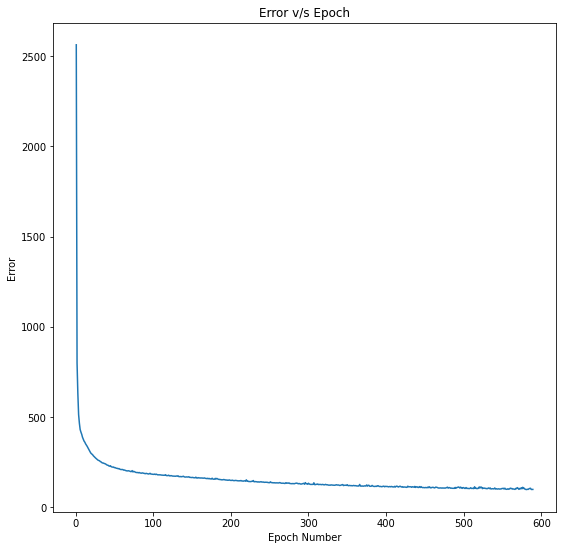

Hidden Layer Activation = tanh
MSE on Train Set: 53.62731016535752
MSE on Test Set: 148.804107594547


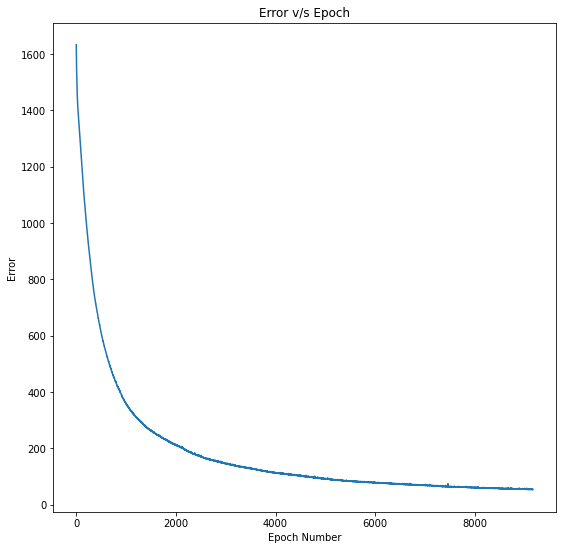

In [0]:
activations = ['relu', 'tanh']

get_f = {'tanh' : (lambda x: np.tanh(x)), 'relu': (lambda x: np.maximum(0, x))}
get_f_prime = {'tanh': (lambda x: 1 - np.power(np.tanh(x), 2)), 'relu': (lambda x: np.greater(x, 0))}

for active in activations:
    train_loss, test_error, _, _ = batch_backprop_train(64, get_f[active], get_f_prime[active])
    print("Hidden Layer Activation = " + str(active))
    print("MSE on Train Set: " + str(train_loss[-1]))
    print("MSE on Test Set: " + str(test_error))
    plot_losses(train_loss)

---
$ How\ scikit-learn\ makes\ our\ life\ easier $

---

In [0]:
# Using sklearn's implementation of SGD with 10000 iterations
def train(X, y, n_nodes = 64, active = 'relu'):
    reg = MLPRegressor(alpha = 0,
                       learning_rate_init = 1e-4 * 5,
                       hidden_layer_sizes = (n_nodes),
                       random_state = 2020,
                       activation = active,
                       max_iter = int(1e5),
                       solver = 'sgd',
                       momentum = 0)
    reg.fit(X, y)
    return reg
    # reg is our trained model
    
def plot_loss_curve(reg):
    fig = plt.figure(figsize=(9, 9))
    p = fig.add_subplot('111')
    p.set_title('Error v/s Epoch')
    p.set_xlabel('Epoch Number')
    p.set_ylabel('Error')
    errors = reg.loss_curve_
    p.plot(list(range(1, len(errors))), errors[1:])
    plt.show()

def get_train_test_loss(reg):
    pred_y_train = reg.predict(X_train)
    pred_y_test = reg.predict(X_test)
    
    train_Loss = np.power(np.linalg.norm(y_train - pred_y_train), 2) / np.shape(y_train)[0]
    test_Loss = np.power(np.linalg.norm(y_test - pred_y_test), 2) / np.shape(y_test)[0]

    return (train_Loss, test_Loss)

Hidden Layer Activation = relu
Error on Train Set: 36.44956677106501
Error on Test Set: 55.26414280780258


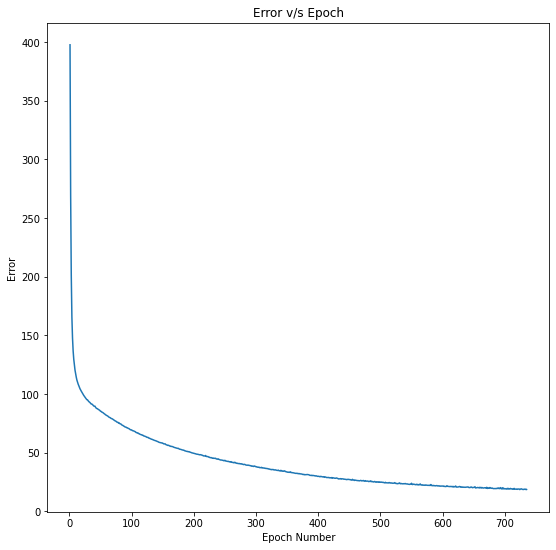

Hidden Layer Activation = tanh
Error on Train Set: 34.0734854366935
Error on Test Set: 38.8442597619366


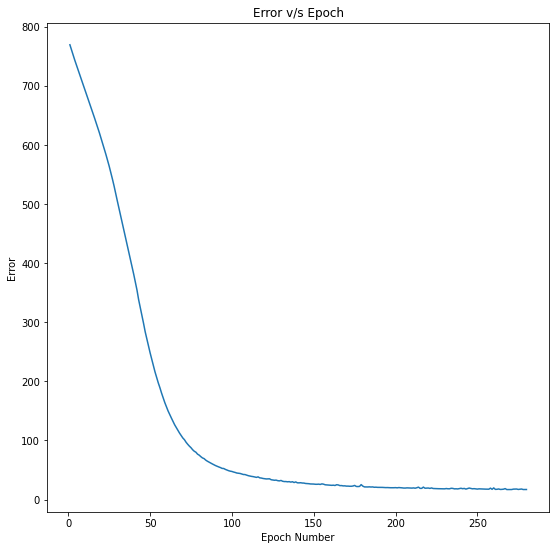

In [0]:
# obtaining results using scikit learn

for active in activations:
    model = train(X_train, y_train, 64, active)
    print("Hidden Layer Activation = " + str(active))
    loss_train, loss_test = get_train_test_loss(model)
    print("Error on Train Set: " + str(loss_train))
    print("Error on Test Set: " + str(loss_test))
    plot_loss_curve(model)

## $ If\ you're\ interested\ in\ optimization\ and\ learning, $
### $ try\ including\ bias\ terms\ in\ the\ vanilla\ model\ and\ evaluate\ the\ new\ performance.$

#### $ This\ should\ give\ you\ a\ head\ start: $

$ if\ we\ define\ our\ model\ as: $

$ y' = W_2.f(W_1^TX + b_1) + b_2$

$where:$

- $\ W_1\ is\ of\ size\ 8\ \times\ n\_nodes$

- $\ W_2\ is\ of\ size\ 1\ \times\ n\_nodes$

- $\ b_1 \in\ \mathbb{R}^{n\_nodes}$

- $\ b_2\ \in\ \mathbb{R}$

- $\ f\ is\ the\ activation\ for\ the\ hidden\ layer$

- $\ X\ is\ the\ data\ matrix\ of\ size\ 8\times [batch\ size]$

$ What\ else\ do\ we\ need\ to\ consider? $

#### $ HINT:\ Think\ about\ \frac{\partial L}{\partial b_1}\ and\ \frac{\partial L}{\partial b_2}$

In [0]:
# ^_^ Thank You